In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%load_ext rpy2.ipython

In [2]:
# Load data
data = pd.read_csv('../../data/behavioral_data.csv')
# Filter out trials with RT < 0.2 or response_int.isna()
data = data.query('RT > 0.2 & response_int.notna()')

<Axes: xlabel='RT', ylabel='Density'>

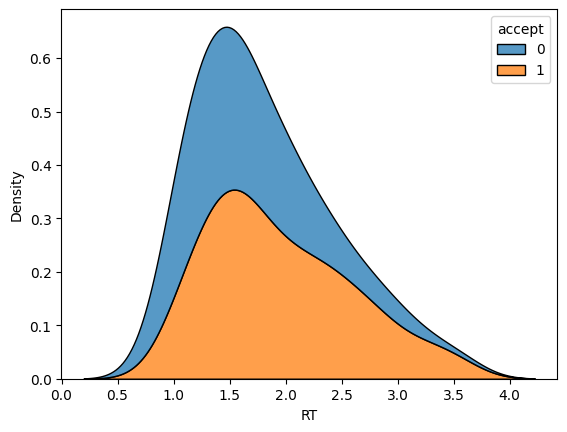

In [5]:
sns.kdeplot(data=data.query("sub == 109"), x='RT', hue='accept', multiple='stack')

In [3]:
%%R -i data
library(lme4)
library(lmerTest)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



**Equal Indifference condition(high-payoff) has more acceptances than Equal Range condition (low-payoff)**

In [5]:
%%R
# Model 1: Predict acceptance rate as a function of condition, gain, loss, and distance from indifference
model1 <- glmer(accept ~ condition*gain + condition*loss + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
  6733.3   6786.0  -3359.6   6719.3    13729 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-260.486   -0.154    0.022    0.201  216.884 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 4.503    2.122   
Number of obs: 13736, groups:  sub, 54

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.248046   0.430556   0.576   0.5645    
conditionequalRange      -1.036262   0.618566  -1.675   0.0939 .  
gain                      0.321002   0.008887  36.121   <2e-16 ***
loss                     -0.476398   0.014630 -32.563   <2e-16 ***
conditionequalRange:gain  0.386159   0.022132  17.448   <2e-16 ***
conditionequalRange:loss -0.206953   0.024

In [29]:
print("High reward mean acceptance rate:", data.query("condition == 'equalIndifference'")["accept"].mean())
print("Low reward mean acceptance rate:", data.query("condition == 'equalRange'")["accept"].mean())

High reward mean acceptance rate: 0.688623595505618
Low reward mean acceptance rate: 0.46961910519951633


In [30]:
# acceptance mean for shared gambles
shared_gains = [10, 12, 14, 16, 18, 20]
print("High reward mean acceptance rate for shared gains:", data.query("condition == 'equalIndifference' & gain in @shared_gains")["accept"].mean())
print("Low reward mean acceptance rate for shared gains:", data.query("condition == 'equalRange' & gain in @shared_gains")["accept"].mean())


High reward mean acceptance rate for shared gains: 0.39865118021730983
Low reward mean acceptance rate for shared gains: 0.6013704151551794


In [18]:
%%R
# Model 2: Predict Response Time as a function of condition, gain, loss, and distance from indifference
model2 <- lmer(RT ~ condition*accept +(1|sub), data=data)
summary(model2) 

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ condition * accept + (1 | sub)
   Data: data

REML criterion at convergence: 20420.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5124 -0.6714 -0.1795  0.5197  5.0284 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09727  0.3119  
 Residual             0.25398  0.5040  
Number of obs: 13736, groups:  sub, 54

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 1.740e+00  5.999e-02  5.466e+01  29.013  < 2e-16
conditionequalRange        -1.674e-01  8.612e-02  5.382e+01  -1.943   0.0572
accept                     -8.180e-02  1.370e-02  1.371e+04  -5.969 2.45e-09
conditionequalRange:accept  2.398e-02  1.895e-02  1.371e+04   1.265   0.2058
                              
(Intercept)                ***
conditionequalRange        .  
accept                     ***
conditionequ

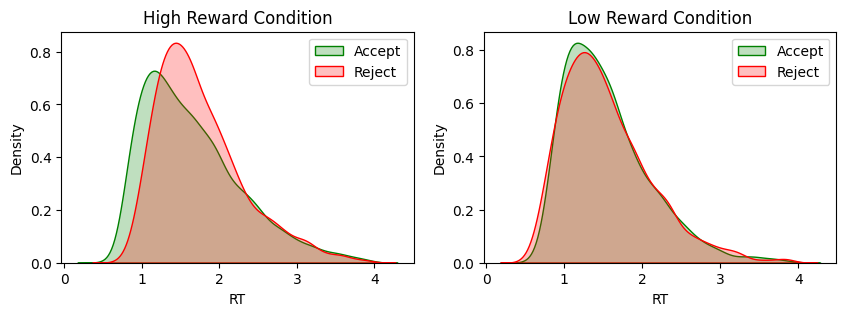

In [19]:
# For each condition, do a histograme of RT based on accept
# Figure with two subplots, one for each condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=data.query('condition == "equalIndifference" & accept == 1'), x='RT', fill=True, color='green', label='Accept', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalIndifference" & accept == 0'), x='RT', fill=True, color='red', label='Reject', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalRange" & accept == 1'), x='RT', fill=True, color='green', label='Accept', ax=axs[1]) 
sns.kdeplot(data=data.query('condition == "equalRange" & accept == 0'), x='RT', fill=True, color='red', label='Reject', ax=axs[1])
axs[0].set_title('High Reward Condition')
axs[1].set_title('Low Reward Condition')
axs[0].legend()
axs[1].legend()
plt.show()


<Axes: xlabel='RT_quantile', ylabel='accept'>

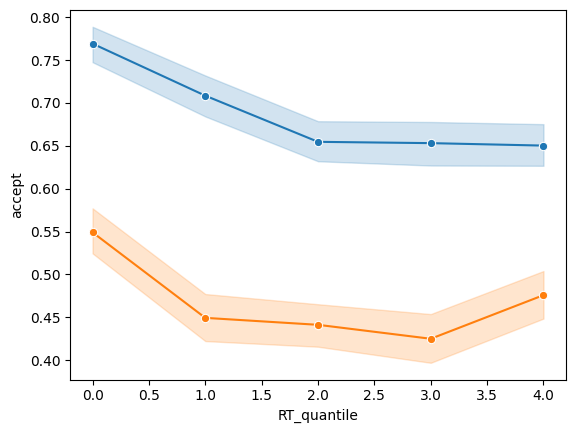

In [27]:
# Divide the RT into 5 quantiles per subject
data['RT_quantile'] = data.groupby('sub')['RT'].transform(lambda x: pd.qcut(x, 5, labels=False))

sns.lineplot(data.query("condition == 'equalIndifference'"), x='RT_quantile', y='accept', marker='o')
sns.lineplot(data.query("condition == 'equalRange'"), x='RT_quantile', y='accept', marker='o')



In [19]:
data

,Unnamed: 0,sub,run,condition,gain,loss,RT,accept,response_int,participant_response,trial,uncertain,dist_from_indiff,gain/loss,accept_mean,RT_quantile
0,512,3,1,equalIndifference,14,14,1.247,1,4.0,strongly_accept,1,0,0.000000,1.000000,0.238095,2
1,513,3,1,equalIndifference,38,14,1.041,1,4.0,strongly_accept,2,0,16.970563,2.714286,0.892857,1
2,514,3,1,equalIndifference,10,18,2.803,1,3.0,weakly_accept,3,1,5.656854,0.555556,0.071429,4
3,515,3,1,equalIndifference,16,5,0.936,1,4.0,strongly_accept,4,0,7.778175,3.200000,0.982143,0
4,516,3,1,equalIndifference,40,12,1.142,1,4.0,strongly_accept,5,0,19.798990,3.333333,0.976190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13819,27643,124,4,equalRange,7,14,1.235,0,1.0,strongly_reject,252,0,4.949747,0.500000,0.019231,1
13820,27644,124,4,equalRange,5,9,1.236,0,1.0,strongly_reject,253,0,2.828427,0.555556,0.057692,1
13821,27645,124,4,equalRange,5,15,1.030,0,1.0,strongly_reject,254,0,7.071068,0.333333,0.019231,0
13822,27646,124,4,equalRange,12,18,1.029,0,1.0,strongly_reject,255,0,4.242641,0.666667,0.038462,0
